___

In [7]:
import os

def windowsOrMacDirectories():
    """ Sets base directories for win or mac

       
    """
    if os.environ['COMPUTERNAME'] == 'SHEALMACLEARN':
        DropboxDirect = os.path.join("D:\Dropbox")
#     elif sys.platform.startswith('linux') or sys.platform.startswith('cygwin'):
#         # this excludes your current terminal "/dev/tty"
    elif sys.platform.startswith('darwin'):
        DropboxDirect = os.path.join("/Users/cswitzer/Dropbox")
    else:
        raise EnvironmentError('Unknown computer platform')
    
    baseDir = os.getcwd()
    dataDir = os.path.join(DropboxDirect, 'mothMachineLearning_dataAndFigs', 'Data')
    figDir = os.path.join(DropboxDirect, 'mothMachineLearning_dataAndFigs', 'Figs')
    return baseDir, dataDir, figDir


baseDir, dataDir, figDir = windowsOrMacDirectories()
print(dataDir)

D:\Dropbox\mothMachineLearning_dataAndFigs\Data


In [8]:
import pandas as pd

def readMyFile(filename):
    
    '''Read in csv 10x faster than pandas'''
    
    tmpdta = []
 
    with open(filename, newline="\n") as csvDataFile:
        csvReader = csv.reader(csvDataFile, delimiter=' ', quoting=csv.QUOTE_NONNUMERIC)
        for row in csvReader:
            tmpdta.append(row)
 
    return(pd.DataFrame(np.transpose(tmpdta)))

In [9]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import os
import csv
import time
from scipy import signal
import itertools as it

In [10]:
# read in data
spray2 = pd.read_csv(os.path.join(dataDir, "Q_secondspray.csv"), header = None)
forceAngle2 = pd.read_csv(os.path.join(dataDir, "ValSp3_secondspray.csv"), header = None)
spray2.shape

spray1 = pd.read_csv(os.path.join(dataDir, "Q_firstspray.csv"), header = None)
forceAngle1 = pd.read_csv(os.path.join(dataDir, "ValSp3_firstspray.csv"), header = None)

spray = pd.concat((spray1, spray2), axis=1, ignore_index = True)
forceAngle = pd.concat((forceAngle1, forceAngle2), axis=1, ignore_index=True)
spray.shape

(100, 40000)

In [11]:
new_cols = ["x", "y", "theta", "phi", "x_dot", "y_dot", "theta_dot", "phi_dot"]

spray.rename(columns=dict(zip(spray.columns[[np.arange(8)]], new_cols)), inplace=True)

In [ ]:
# create dataset

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 3

trainX, trainY = create_dataset(dataset[0:int(dataset.shape[0]*0.75)], look_back)
testX, testY = create_dataset(dataset[(int(dataset.shape[0]*0.75)+1):], look_back)

print(trainY.shape)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [4]:
# read in dataset that was pre-classified
buzzClassDataDir = os.path.join("D:\Dropbox\SonicationBehavior\SonBehData\BuzzPartClassification")
buzzClass = pd.read_csv(os.path.join(buzzClassDataDir, 'BuzzClassifications.csv'))
print(buzzClass.shape)
buzzClass.head()

(200, 7)


,fileName,noise1,noise2,wing1,wing2,buzz1,buzz2
0,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0,0,0,0,0,20000
1,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0,0,10000,20000,0,10000
2,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0,0,0,0,0,20000
3,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0,0,3000,10000,12500,20000
4,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0,0,0,0,0,20000


In [5]:
# read in all data into a single dataframe
bigList = []
freqSpec = []
for ii in range(buzzClass.shape[0]):
    tmp = readMyFile(buzzClass.fileName[ii])
    
    # pad with 0's
    tmp = readMyFile(buzzClass.fileName[ii])
    pad = np.arange(tmp.iloc[-1,0],tmp.iloc[-1,0]+ 0.02 - np.mean(np.diff(tmp.iloc[:,0])),  np.mean(np.diff(tmp.iloc[:,0])))
    zx = np.repeat(0, len(pad))
    pdff = pd.DataFrame( data = {"0":pad, "1":zx} )
    pdff.columns = tmp.columns

    tmp = pd.concat([tmp, pdff]).reset_index(drop = True)
    
    # calculate rolling variance
    tmp["varia"] = pd.Series((tmp.iloc[:,1] - np.mean(tmp.iloc[:,1]))).rolling(int(2000), center = True, min_periods = 1).var().tolist()
    
    # calculate frequency spectrum
    f, t, Sxx = signal.spectrogram(tmp.iloc[:,1], 200000, noverlap = 900, nperseg = 1000)
    Sxx = Sxx[0:50, :]
    #scale
    Sxx = Sxx - np.min(Sxx)
    Sxx = Sxx / np.max(Sxx)
    
    
    
    freqSpec.append(pd.DataFrame(np.transpose(Sxx)))
    
    # add classes to data
    tmp["buzz"] = 0
    tmp.loc[buzzClass.buzz1[ii]:buzzClass.buzz2[ii], "buzz"] = 1
    if(np.mod(ii, 10)) == 0:
        print(ii)
    
    tmp["filename"] = buzzClass.fileName[ii]
    bigList.append(tmp)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


In [ ]:
df = pd.concat(bigList)
df.reset_index(drop = True, inplace = True)

In [ ]:
df.head()

In [ ]:
plt.plot(df.iloc[0:20000, 1])

In [ ]:
df.shape

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
mm = MinMaxScaler((0,1))
mm.fit(df.iloc[:, 1].values.reshape(-1, 1))
df["scaledBuzz"] = mm.transform(df.iloc[:, 1].values.reshape(-1, 1))


subSamp = np.arange(0, 20000, step = 50)# np.arange(0, df.shape[0], step = 5)
plt.figure(figsize=(20,5))
plt.plot(np.array(df.index[subSamp]), np.array(df.iloc[subSamp,5]))
#plt.scatter(df.index[subSamp], df.iloc[subSamp,2]*10, s = 0.5, c = df.iloc[subSamp,3])
plt.show()
df.shape

In [ ]:
# downsample dataset
print(df.shape)
subSamp = np.arange(0, df.shape[0], step = 10)# np.arange(0, df.shape[0], step = 5)
df = df.iloc[subSamp, :]
print(df.shape)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

In [ ]:
seq = df.loc[:,"scaledBuzz"]

# timesteps = np.linspace(0, 2, num = 2000000)
# freq = ((np.sin(timesteps*timesteps/2*10*2*np.pi) + 1)**3 > 4 ) + 0.3
# seq = np.sin((freq*100 * timesteps) * 2 * np.pi)
# plt.plot(timesteps, seq)
# plt.plot(timesteps, freq + 1)

In [ ]:
from scipy import signal

f, t, Sxx = signal.spectrogram(np.array(seq), 200000, noverlap = 4000, nperseg = 5000)
Sxx = Sxx[0:10]
f = f[0:10]
plt.pcolormesh(t, f, Sxx)
plt.ylim(0,500)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
# buzzes = freq > 1.0
buzzes = df.buzz
plt.plot(buzzes[0:1000000])

In [ ]:
# scale dataset
from sklearn.preprocessing import MinMaxScaler
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(np.array(seq).reshape(-1,1))
plt.plot(dataset[0:10000])

In [ ]:
# create dataset

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 100

trainX, trainY = create_dataset(dataset[0:int(dataset.shape[0]*0.75)], look_back)
testX, testY = create_dataset(dataset[(int(dataset.shape[0]*0.75)+1):], look_back)

print(trainY.shape)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))



In [ ]:
trainX.shape
plt.figure(figsize=[10,5])
plt.plot(trainX[0:5000, 0, -1])

trainY= np.array(buzzes[look_back:(trainX.shape[0]+look_back)])
plt.plot(trainY[0:5000])

# refref: alignment might be off

In [ ]:
np.array(testY)

In [ ]:
testY=np.array(buzzes[(trainX.shape[0]+look_back):(trainX.shape[0] + look_back + testY.shape[0])])
plt.figure(figsize=[20,5])
plt.plot(testX[0:500000,0,0])
plt.plot(testY[0:500000])

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import TimeDistributed
from keras.callbacks import EarlyStopping


earlystop = EarlyStopping(monitor='loss', patience=100, verbose=1, mode='auto', min_delta = 0.0001)

# create and fit the LSTM network
model = Sequential()
model.add(CuDNNLSTM(400, input_shape=(1, look_back), return_sequences = True))
model.add(CuDNNLSTM(4, return_sequences = False))
# refref add more layers, and increase lookback
#model.add(Dense(4, input_shape=(1, trainX.shape[2] )))
model.add((Dense(1, activation = "sigmoid")))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hitory = model.fit(trainX, trainY, epochs=1000, batch_size=150000, verbose=1, callbacks = [earlystop])

Epoch 1/1000
359884/359884 [==============================] - 1s 4us/step - loss: 0.6854 - acc: 0.5905
Epoch 2/1000
359884/359884 [==============================] - 1s 2us/step - loss: 0.6752 - acc: 0.5979
Epoch 3/1000
359884/359884 [==============================] - 1s 2us/step - loss: 0.6761 - acc: 0.5979
Epoch 4/1000
359884/359884 [==============================] - 1s 2us/step - loss: 0.6740 - acc: 0.5979
Epoch 5/1000
359884/359884 [==============================] - 1s 2us/step - loss: 0.6745 - acc: 0.5979
Epoch 6/1000
359884/359884 [==============================] - 1s 2us/step - loss: 0.6748 - acc: 0.5979
Epoch 7/1000
359884/359884 [==============================] - 1s 2us/step - loss: 0.6743 - acc: 0.5979
Epoch 8/1000
359884/359884 [==============================] - 1s 2us/step - loss: 0.6739 - acc: 0.5979
Epoch 9/1000
359884/359884 [==============================] - 1s 2us/step - loss: 0.6740 - acc: 0.5979
Epoch 10/1000
359884/359884 [==============================] - 1s 2us/ste

In [ ]:
print(hitory.history.keys())


plt.plot(hitory.history['loss'], c = "orange")
plt.title('Neural network loss')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper right')
plt.xlabel('epoch')
plt.show()

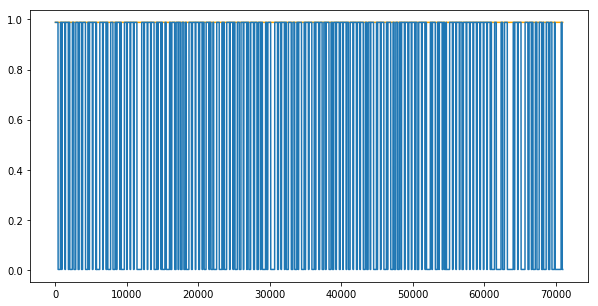

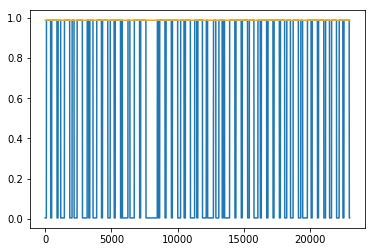

In [32]:
trainY = trainY.reshape(-1)
testY = testY.reshape(-1)

# make predictions
trainPredict = model.predict_classes(trainX)
testPredict = model.predict_classes(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# plot
plt.figure(figsize = [10, 5])
plt.plot(trainPredict, c="orange")
plt.plot(trainY[0,:])

plt.show()

plt.plot(testY[0,:])
plt.plot(testPredict[1:], c= 'orange')

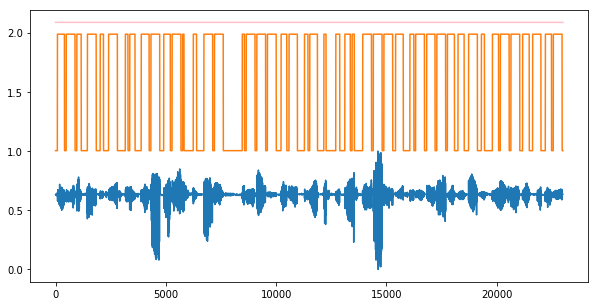

In [33]:
plt.figure(figsize = [10, 5])
plt.plot(testX[0:200000,0, 0])
plt.plot(testPredict[0:200000] + 1.1, c= 'pink')
plt.plot(testY[0,0:200000] + 1)